In [337]:
import numpy as np
import pandas as pd
import copy

import plotly as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [212]:
# Importing the WISE3.1 soil layers dataset
df_orig = pd.read_csv("WISE3_HORIZON.csv",sep=';')
df_orig.head()

,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,MCOLOR,DCOLOR,ORGC,TOTN,CACO3,...,CECSOIL,BSAT,SAND,SILT,CLAY,GRAVEL,BULKDENS,VMC1,VMC2,VMC3
0,AF0001,1,NaN,0,15,10YR4/3,10YR4/2,"7,6","0,6",93,...,NaN,NaN,40.0,40.0,20.0,20.0,NaN,NaN,NaN,NaN
1,AF0001,2,NaN,15,60,10YR5/3,10YR5/2,"2,3","0,3",177,...,NaN,NaN,10.0,55.0,35.0,NaN,NaN,NaN,NaN,NaN
2,AF0001,3,NaN,60,150,10YR5/3,NaN,"0,9","0,3",182,...,NaN,NaN,10.0,55.0,35.0,NaN,NaN,NaN,NaN,NaN
3,AF0002,1,NaN,0,20,10YR4/2,NaN,"12,8","0,9",191,...,NaN,NaN,40.0,40.0,20.0,NaN,NaN,NaN,NaN,NaN
4,AF0002,2,NaN,20,60,10YR4/2,NaN,6,"0,6",192,...,NaN,NaN,15.0,65.0,20.0,NaN,NaN,NaN,NaN,NaN


The idea is to use soil texture values to infer water readily available to plants

Field capacity (θfc) is the bulk water content retained in soil at −33 kPA/kg of suction pressure (VMC2 in our case). As we're interested in a relative value, I'm keeping the volumetric measures and not converting them to quantities.

Wilting point (θpwp) is by convention set equal to the water content at −1,500 kPa (−15 bar) of suction pressure.

Water readily available to plants is the difference between the soil water content at field capacity (θfc) and permanent wilting point (θpwp):

θa ≡ θfc − θpwp

Later I define 'W_INDEX' as θa/θfc to have a relative % over total field capacity.


In [213]:
# picking columns of interest
df = copy.deepcopy(df_orig.loc[:,['SAND','SILT','CLAY','VMC2','VMC3']])

In [214]:
df.dropna(inplace=True)
display(df)

,SAND,SILT,CLAY,VMC2,VMC3
48,12.0,66.0,22.0,34.0,17.0
49,10.0,67.0,23.0,34.0,17.0
50,1.0,68.0,31.0,37.0,19.0
51,2.0,38.0,60.0,39.0,31.0
52,18.0,63.0,19.0,34.0,14.0
...,...,...,...,...,...
47720,19.0,15.0,66.0,71.0,45.0
47722,15.0,17.0,68.0,79.0,46.0
47723,12.0,18.0,70.0,85.0,54.0
47724,8.0,18.0,74.0,85.0,60.0


In [215]:
all(df['SAND'] +  df['SILT'] + df['CLAY'] == 100)

False

In [358]:
#dropping rows for which percentages go past 100
df = df[df['SAND'] +  df['SILT'] + df['CLAY'] == 100]

In [260]:
all(df['SAND'] +  df['SILT'] + df['CLAY'] == 100)

True

In [362]:
w_aval_array = [row['VMC2'] - row['VMC3'] for _,row in df.iterrows()]

In [253]:
w_index_array = [w_aval_array[i] / df['VMC2'].values[i] * 100 for i in range(len(df['VMC2']))]

In [219]:
df['W_INDEX'] = w_index_array
display(df)

,SAND,SILT,CLAY,VMC2,VMC3,W_INDEX
48,12.0,66.0,22.0,34.0,17.0,50.000000
49,10.0,67.0,23.0,34.0,17.0,50.000000
50,1.0,68.0,31.0,37.0,19.0,48.648649
51,2.0,38.0,60.0,39.0,31.0,20.512821
52,18.0,63.0,19.0,34.0,14.0,58.823529
...,...,...,...,...,...,...
47720,19.0,15.0,66.0,71.0,45.0,36.619718
47722,15.0,17.0,68.0,79.0,46.0,41.772152
47723,12.0,18.0,70.0,85.0,54.0,36.470588
47724,8.0,18.0,74.0,85.0,60.0,29.411765


In [243]:
df_ready = df.loc[ df['W_INDEX']  >= 0, ['SAND','SILT','W_INDEX']]

In [244]:
df_ready.reset_index(inplace = True, drop = True)

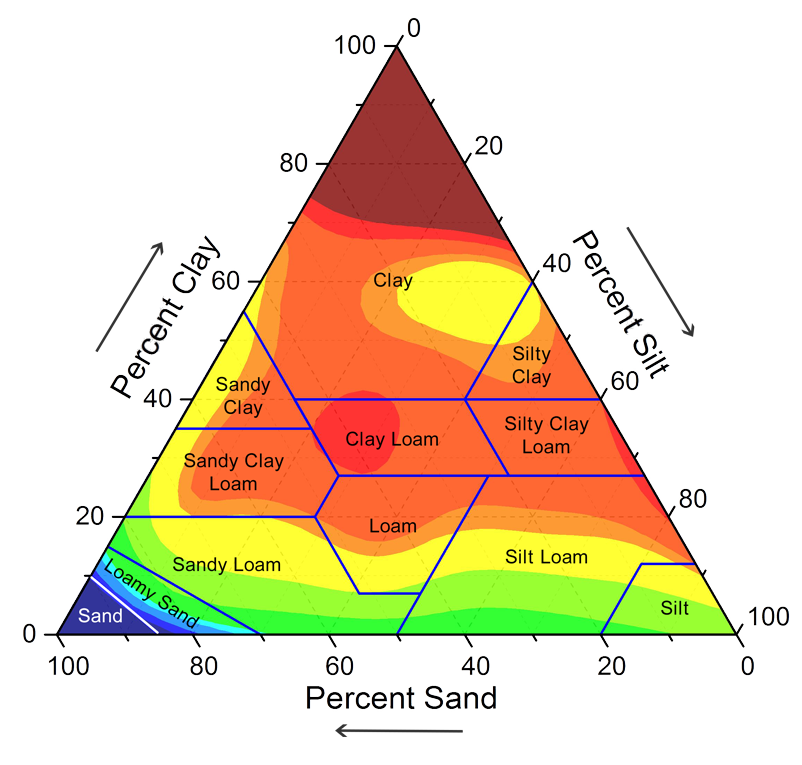

We're using only SAND %, SILT %, CLAY % - dropping CLAY % for computation as can be retrieved knowing SAND and SILT %, and ignoring Loam as its own classification as it seems to be just the result of specific combinations S/S/C.

In [245]:
display(df_ready)

,SAND,SILT,W_INDEX
0,12.0,66.0,50.000000
1,10.0,67.0,50.000000
2,1.0,68.0,48.648649
3,2.0,38.0,20.512821
4,18.0,63.0,58.823529
...,...,...,...
5858,19.0,15.0,36.619718
5859,15.0,17.0,41.772152
5860,12.0,18.0,36.470588
5861,8.0,18.0,29.411765


In [357]:
hist = px.histogram(df_ready['W_INDEX'].values)
hist.layout.update(showlegend=False)
display(hist)

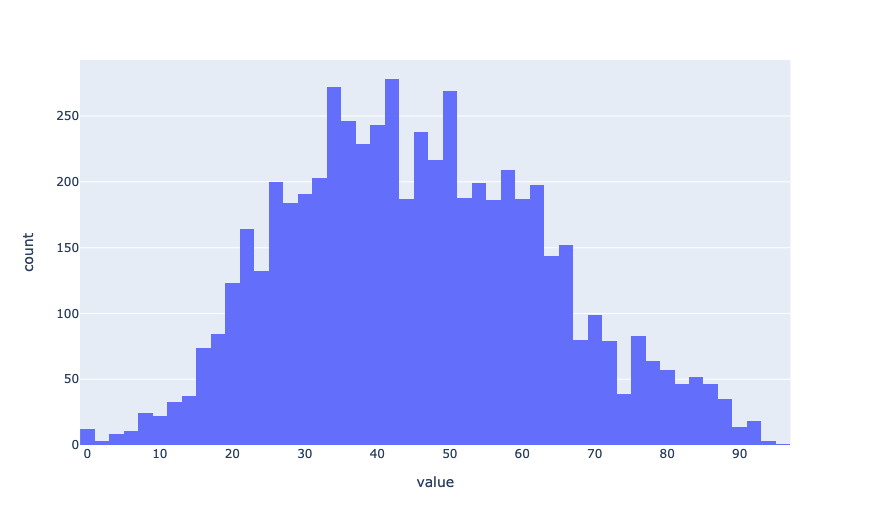

Using random forest to fit SAND, SILT, W_INDEX data:

In [246]:
X = df_ready.iloc[:, 0:2].values
y = df_ready.iloc[:, -1].values

In [259]:
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2) 

In [257]:
model = RandomForestRegressor(n_estimators=40, max_samples=0.8)
model.fit(X, y) #training on whole set
y_pred = model.predict(X_test)

In [250]:
y_pred

array([45.72043562, 47.36873584, 50.41595945, ..., 36.54367792,
       43.75222769, 43.58872549])

In [251]:
y_test

array([37.5       , 50.        , 57.14285714, ..., 43.18181818,
       54.16666667, 36.        ])

In [252]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 7.980099255806975
Mean Squared Error: 115.14130541760528
Root Mean Squared Error: 10.730391671211507


Predicting values for W_INDEX for different SILT/SAND/(CLAY) combinations

In [270]:
silt_array = np.linspace(5,100,250)

In [271]:
sand_array = np.linspace(5,100,250)

In [344]:
n = len(sand_array)
pred_w_index = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        ss = np.zeros((1,2))
        ss[0][0] = sand_array[i]
        ss[0][1] = silt_array[j]
        
        #computing only on allowable sand/silt/(clay) combinations
        pred_w_index[i][j] = np.nan if np.sum(ss) > 100 else model.predict(ss)


In [345]:
fig = go.Figure(data=[go.Surface(z=pred_w_index, x=sand_array, y=silt_array)])

In [350]:
fig.update_layout(scene = dict(
                    xaxis_title='SAND %',
                    yaxis_title='SILT %',
                    zaxis_title='W_INDEX %'),)

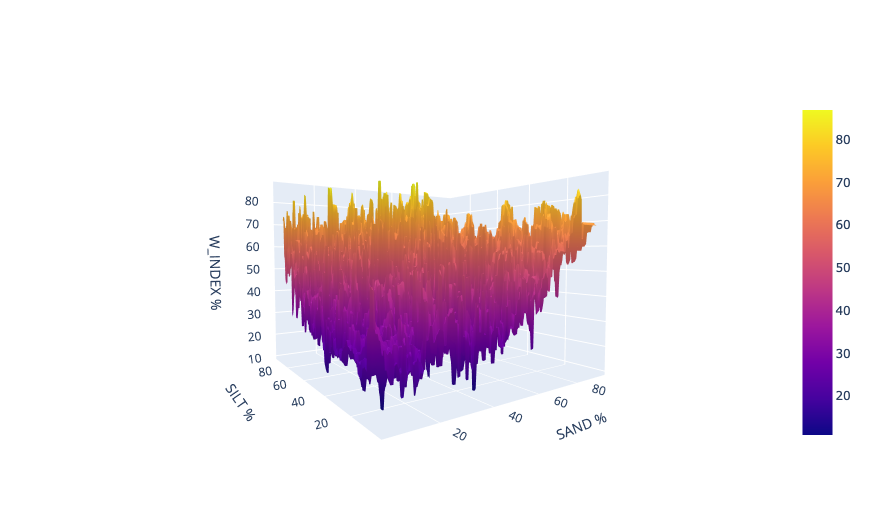